# My first post about statmodels - so be nice! :)

Bernardo Freire  
8/1/23

# Introduction: Play with GLMs

During my study at
[HSLU](https://www.hslu.ch/en/lucerne-school-of-business/degree-programmes/master/applied-information-and-data-science/)
I have learned to use mostly [`R`](https://www.r-project.org/) when it
comes to statistic and for some machine learning courses as well. When
it comes to work, the most companies I have seen so far, use `Python` as
their main programming language. My previous two employers used `Python`
and `R`. **This article is not going to discuss which language is
better, but rather focus on how to use `Python` and the library
`statmodels` which seems to produce similar outputs as it would in
`R`.**

One important and cool thing about the `statmodels` library is that it
has a lot of data sets already included. You can find them
[here](https://www.statsmodels.org/stable/datasets/index.html). The data
set I use is a `R` data set from
[Rdatasets](https://vincentarelbundock.github.io/Rdatasets/). In
particular, the dataset from the package `modeldata` called `car_prices`
is used.

``` python
## Data imports
df = (
    statsmodels.api # imported as sm in following code
    .datasets
    .get_rdataset("car_prices", package='modeldata')
    .data
)
```

Another important thing about this blog post is the usage of
[`Quarto`](https://quarto.org/). Quarto allowed me to write this blog
post directly from a Jupyter-Notebook without any fancy and complicated
transformations. For more information, please visit the quarto website.

However, let’s start with the analysis. The first thing we do is to
import the necessary libraries and the data set.

In [1]:
## Data manipulation imports
import pandas as pd
import numpy as np

## Display imports
from IPython.display import display, Markdown

## statmodels import
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.genmod.families.family as fam
from patsy import dmatrices

## Plot imports
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,5/2.5)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_theme()
sns.set_context(
    "paper", 
    rc={
        "figsize"       :   plt.rcParams['figure.figsize'],
        'font_scale'    :   1.25,
    }
)


## Data imports
df = (
    sm
    .datasets
    .get_rdataset("car_prices", package='modeldata')
    .data
)

# Explanatory Data Exploration

The data exploration is a crucial step before fitting a model. It allows
to understand the data and to identify potential problems. In this
notebook, we will explore very briefly the data, as the focus of this
article is to understand and apply `statmodels`.

First, two approximately continous variables `Price` and `Mileage` are
investigated by means of graphical analysis. The following bar plots
show the distribution of the two variables.

``` python
height = plt.rcParams['figure.figsize'][0]
aspect = plt.rcParams['figure.figsize'][0]/plt.rcParams['figure.figsize'][1] / 2

g1 = sns.displot(
    data = df,
    x = 'Price',
    kde = True,
    height = height,
    aspect = aspect,
)
plt.title('Distribution of car price')
plt.xlabel('Price')
plt.ylabel('Count of occurance')
plt.show(g1)

g2 = sns.displot(
    data = df,
    x = 'Mileage',
    kde = True,
    height = height,
    aspect = aspect,
)
plt.title('Distribution of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Count of occurance')
plt.show(g2)
```

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: center;"><div class="output display_data"
width="50.0%" data-layout-align="center">
<figure>
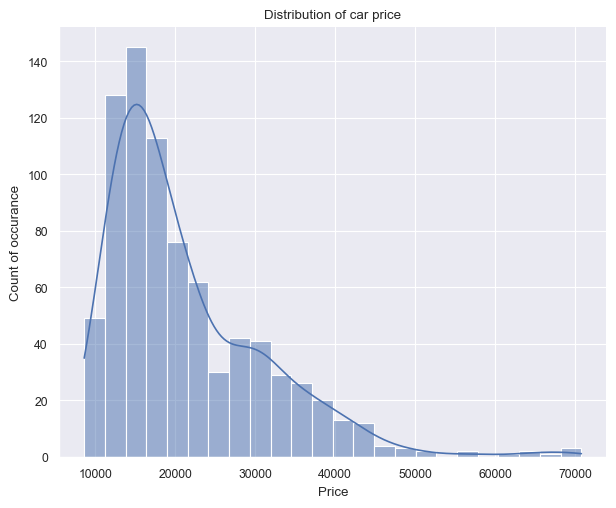
<figcaption aria-hidden="true">(a) Distribution of the variable
Price</figcaption>
</figure>
</div></td>
<td style="text-align: center;"><div class="output display_data"
width="50.0%" data-layout-align="center">
<figure>
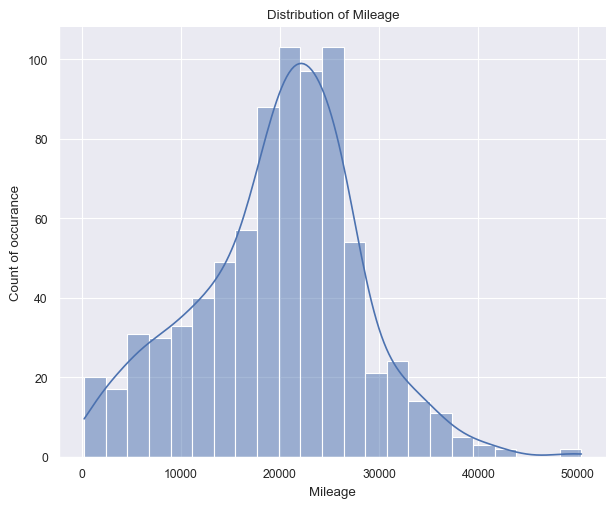
<figcaption aria-hidden="true">(b) Distribution of the variable
Mileage</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 1: Distribution of price and mileage variables.

[Figure 1 (a)](#fig-distplot-1) shows on the left a right-skewed
distribution with a peak around 15k\$ and price values ranging from 8k
dollars to 70k dollars. On the other hand, [figure 1
(b)](#fig-distplot-2) shows on the right a more ballanced distribution
with a peak around 20k\$ and price values ranging from 266 miles up to
50k miles.

Proceeding to the next two variables, `Cylinder` and `Doors`, one can
see less possible values, ranging from

``` python
height = plt.rcParams['figure.figsize'][0]
aspect = plt.rcParams['figure.figsize'][0]/plt.rcParams['figure.figsize'][1] / 2

g = sns.displot(
    data = df,
    x = 'Cylinder',
    discrete = True,
    height = height,
    aspect = aspect,
)
plt.title('Distribution of Cylinder')
plt.xlabel('Cylinder')
plt.ylabel('Count of occurance')
plt.show(g)

# plt.figure()
g = sns.displot(
    data = df,
    x = 'Doors',
    discrete = True,
    shrink = 0.5,
    height = height,
    aspect = aspect,
)
plt.title('Distribution of Doors')
plt.xlabel('Doors')
plt.ylabel('Count of occurance')
plt.show(g)
```

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<tbody>
<tr class="odd">
<td style="text-align: center;"><div class="output display_data"
width="50.0%" data-layout-align="center">
<figure>
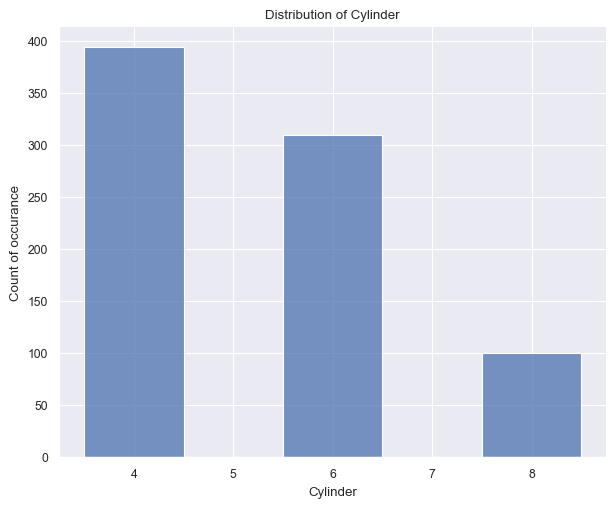
<figcaption aria-hidden="true">(a) Distribution of the variable
cylinder</figcaption>
</figure>
</div></td>
<td style="text-align: center;"><div class="output display_data"
width="50.0%" data-layout-align="center">
<figure>
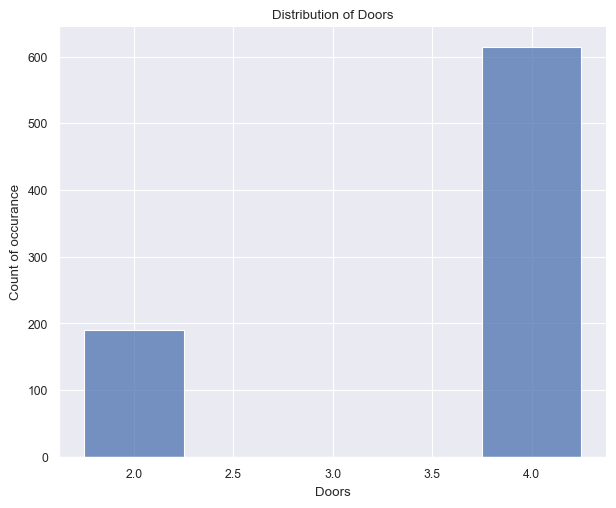
<figcaption aria-hidden="true">(b) Distribution of the variable
doors</figcaption>
</figure>
</div></td>
</tr>
</tbody>
</table>

Figure 2: Distribution of cylinder and doors variables.

The [Figure 2 (a)](#fig-distplot2-1) surprised me quite a bit. I had
anticipated the car to feature more than 8 cylinders, given that this
dataset pertains to American cars. The cylinder count typically spans
from 4 to 8, with the values accurately reflecting this range. It’s
worth noting that the number of cylinders is expected to be even.

Again surprisingly, the [Figure 2 (b)](#fig-distplot2-2) shows that the
number of doors per car. The values are either 2 or 4, with the latter
being more common. This is a bit surprising, as I would have expected
the number of doors to be higher for American cars (SUV).

Next, we check the distribution of the make of the cars in the dataset.
For this analysis, we first pivot the dataframe using `pd.melt()` and
calculate the sum by means of `groupby()` and `sum()` method as follows:

In [8]:
brands = (
    df
    [['Buick', 'Cadillac', 'Chevy', 'Pontiac', 'Saab']]
    .melt()
    .groupby('variable')
    .sum()
    .reset_index()
)

brands.head()

,variable,value
0,Buick,80
1,Cadillac,80
2,Chevy,320
3,Pontiac,150
4,Saab,114


After aggregation, the visualization of the data is as follows:

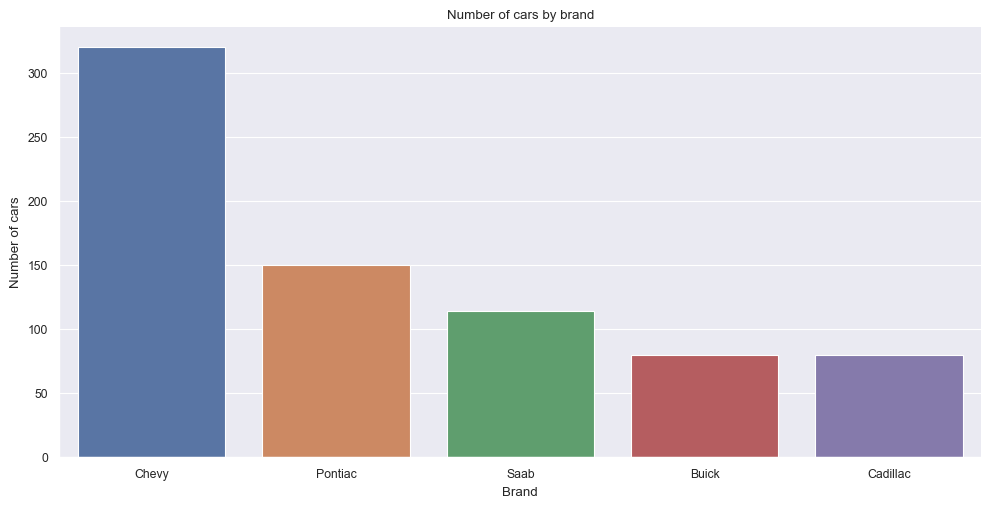

In [9]:
sns.catplot(
    data    = brands.sort_values('value', ascending=False),
    x       = 'variable',
    y       = 'value',
    kind    = 'bar',
    height  = 5,
    aspect  = 2,
)
plt.title('Number of cars by brand')
plt.xlabel('Brand')
plt.ylabel('Number of cars')
plt.show()

In descending order the most present make is: Chevy followed by Pontiac,
Saab, Buick and Cadilac.

At this point it should be mentioned, that the data set is not balanced
and the distribution of the features is not uniform across the different
makes and car features. In a normal project this would be a point to
consider and to take care of. However, for the purpose of this project,
this is not necessary.

# Modeling

Modeling with `statsmodels` becomes straightforward once the formula API
and provided documentation are well understood. I encountered a minor
challenge in grasping the formula API, but once I comprehended it, the
usage turned out to be quite intuitive.

Let’s delve into an understanding of the formula API
(`statsmodels.formula.api`). This feature enables us to employ R-style
formulas for specifying models. To illustrate, when fitting a linear
model, the following formula suffices:

``` python
import statsmodels.formula.api as smf

model = smf.ols(
    formula='y ~ x1 + x2 + x3', 
    data=df
)
```

The formula API leverages the `patsy` package ([Patsy
Package](https://patsy.readthedocs.io/en/latest/formulas.html)). It’s
worth noting that the formula API’s potency extends to intricate models.
Additionally, it’s important to mention that the formula API
automatically incorporates an intercept into the formula if one isn’t
explicitly specified. For cases where the intercept is undesired, a `-1`
can be used within the formula.

With the `glm` class, a vast array of models becomes accessible
importing as follows:

``` python
import statsmodels.genmod.families.family as fam
```

The `fam` import is necessary for specifying the family of the model.
The families available are:

Fitting the model and analyzing the results are the same as one would
using `R`. First define the model, then fit it, then analyze the
results. The details of the fit can be accessed using the `summary`
method.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Price   No. Observations:                  804
Model:                            GLM   Df Residuals:                      789
Model Family:                Gaussian   Df Model:                           14
Link Function:               Identity   Scale:                      8.4460e+06
Method:                          IRLS   Log-Likelihood:                -7544.8
Date:                Thu, 17 Aug 2023   Deviance:                   6.6639e+09
Time:                        11:07:11   Pearson chi2:                 6.66e+09
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Mileage        -0.1842      0.013    -14.664      

After fitting a GLM using the `glm` class in `statsmodels`, you can
obtain a summary of the model’s results using the `.summary()` method on
the fitted model object. Here’s a general overview of the information
typically included in the summary output:

1.  **Model Information:**
    -   The name of the model.
    -   The method used for estimation (e.g., maximum likelihood).
    -   The distribution family (e.g., Gaussian, binomial, Poisson).
    -   The link function used in the model (e.g., logit, identity,
        etc.).
    -   The number of observations used in the model.
2.  **Model Fit Statistics:**
    -   Log-likelihood value.
    -   AIC (Akaike Information Criterion) and/or BIC (Bayesian
        Information Criterion).
    -   Deviance and Pearson chi-square statistics.
    -   Dispersion parameter (if applicable).
3.  **Coefficients:**
    -   Estimated coefficients for each predictor variable.
    -   Standard errors of the coefficients.
    -   z-scores and p-values for testing the significance of the
        coefficients.
4.  **Confidence Intervals:**
    -   Confidence intervals for each coefficient, often at a default
        level like 95%.
5.  **Hypothesis Testing:**
    -   Hypothesis tests for the coefficients, typically with null
        hypothesis being that the coefficient is zero.
6.  **Goodness of Fit:**
    -   Likelihood-ratio test for overall model fit.
    -   Tests for assessing the contribution of individual predictors to
        the model.
7.  **Diagnostic Information:**
    -   Information about model assumptions and diagnostics, depending
        on the type of GLM and the method used.
8.  **Residuals:**
    -   Information about residuals, which can include measures like
        deviance residuals, Pearson residuals, etc.

Refer to the official documentation for the most accurate and up-to-date
information about the summary output for your specific use case.

# Conclusion

Statsmodels is a powerful Python library for statistical modeling and
hypothesis testing, making it an excellent transition for `R` users or
Python users who like `R` to solve certain problems. It offers a
familiar syntax and functionality for regression, ANOVA, and more. Its
integration with Python’s data analysis ecosystem, like pandas, allows
seamless data manipulation. With support for various statistical methods
and a comprehensive summary output, Statsmodels facilitates effortless
migration from R, enabling R users to harness its capabilities in a
Python environment.